# Human Activity Recognition
This notebook provides some guidelines for building a classifier for the MotionSense dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler #
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Added for comprehensive evaluation and visualization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Generate time-series data


In [3]:
def get_ds_infos():
    """
    Read the file includes data subject information.
    
    """
    dss = pd.read_csv("./data_subjects_info.csv")
    print("[INFO] -- Data subjects' information is imported.")
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """
    Selects sensor data types for the dataset.
    
    """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    return dt_list

def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    """
    Generates time-series data from raw sensor files.
    'mode="raw"' is preferred for CNNs to retain directional info.
    """
    if mode == "mag":
        num_data_cols = len(dt_list)
    else:
        num_data_cols = len(dt_list) * 3

    if labeled:
        dataset = np.zeros((0, num_data_cols + 1)) # +1 for activity label
    else:
        dataset = np.zeros((0, num_data_cols))

    ds_list = get_ds_infos()
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = f'./A_DeviceMotion_data/{act}_{trial}/sub_{int(sub_id)}.csv'
                raw_data = pd.read_csv(fname).drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:, x_id] = (raw_data[axes]**2).sum(axis=1)**0.5
                    else:
                        vals[:, x_id*3:(x_id+1)*3] = raw_data[axes].values
                if labeled:
                    lbls = np.array([[act_id]] * len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset, vals, axis=0)

    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]

    if labeled:
        cols += ["act"]

    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

# Define activity and trial codes
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

# Define sensor data types (e.g., all 4 sensor types)
sdt = ["attitude", "gravity", "rotationRate", "userAcceleration"]
print(f"[INFO] -- Selected sensor data types: {sdt}")

# Define activities to classify (e.g., all 6 activities for a comprehensive HAR task)
act_labels = ACT_LABELS # To include all activities
print(f"[INFO] -- Selected activites: {act_labels}")

trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print(f"[INFO] -- Shape of time-Series dataset:{dataset.shape}")
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'gravity', 'rotationRate', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0


# Data Pre-processing

In [4]:
def windows(dataset, window_size=400, stride=200):
    """
    Generates fixed-size windows from the time-series data.
    `window_size` (samples, e.g., 8s at 50Hz) and `stride` (overlap) are tunable hyperparameters.
    """
    X = []
    y = []

    sensor_cols = dataset.columns[:-1] # all except 'act'
    label_col = 'act'

    for start in range(0, len(dataset) - window_size, stride):
        end = start + window_size
        window = dataset.iloc[start:end]
        X.append(window[sensor_cols].values.T) # Shape: (n_sensors, window_size) for 1D CNN
        y.append(window[label_col].mode()[0]) # Majority label in window

    X_windows = np.array(X)
    y_windows = np.array(y)

    print(f"[INFO] -- Created {len(X_windows)} windows of size {window_size}")
    return X_windows, y_windows

# Execute windowing
X_windows, y_windows = windows(dataset, window_size=400, stride=200)

# --- Data Scaling ---
# Apply StandardScaler. Fit on training data only to prevent data leakage.
# Temporarily flatten data for scaler, then reshape back.
n_samples, n_sensors, window_size = X_windows.shape
X_windows_reshaped_for_scaling = X_windows.transpose(0, 2, 1).reshape(-1, n_sensors)

scaler = StandardScaler()


[INFO] -- Created 7063 windows of size 400


# Pytorch Dataset


In [6]:
class MotionSense(Dataset):
    """
    Custom PyTorch Dataset for handling sensor time-series data.
    Ensures data is in appropriate tensor format and types.
    """
    def __init__(self, X, Y):
        if not isinstance(X, torch.Tensor):
            self.X = torch.tensor(X, dtype=torch.float32)
        else:
            self.X = X.detach().clone().float()

        if not isinstance(Y, torch.Tensor):
            self.Y = torch.tensor(Y, dtype=torch.long) # Labels should be long for CrossEntropyLoss
        else:
            self.Y = Y.detach().clone().long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Resampling

In [8]:
# TimeSeriesSplit is crucial for maintaining temporal order and preventing data leakage.
#
ts_cv = TimeSeriesSplit(n_splits=3, gap=20, test_size=500, max_train_size=10000)
splits = list(ts_cv.split(X_windows))

train_idx, test_idx = splits[0] # Use the first split for training and testing

X_train, y_train = X_windows[train_idx], y_windows[train_idx]
X_test, y_test = X_windows[test_idx], y_windows[test_idx]

print(f"Shape of X_train (before scaling): {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test (before scaling): {X_test.shape}, y_test: {y_test.shape}")

# --- Apply Scaling after the split ---
# Fit scaler on training data, then transform both train and test.
X_train_reshaped_for_scaling = X_train.transpose(0, 2, 1).reshape(-1, n_sensors)
X_test_reshaped_for_scaling = X_test.transpose(0, 2, 1).reshape(-1, n_sensors)

X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped_for_scaling)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped_for_scaling) # Transform test with scaler fitted on train

X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape[0], window_size, n_sensors).transpose(0, 2, 1)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape[0], window_size, n_sensors).transpose(0, 2, 1)

# Now, create PyTorch Datasets and DataLoaders using the scaled data
train_dataset = MotionSense(X_train_scaled, y_train)
test_dataset = MotionSense(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Do NOT shuffle test data for consistent evaluation

Shape of X_train (before scaling): (5543, 12, 400), y_train: (5543,)
Shape of X_test (before scaling): (500, 12, 400), y_test: (500,)


# Models


In [9]:
class CNN1D(nn.Module):
    """
    A 1D Convolutional Neural Network for time-series classification.
    Input shape: (batch_size, n_sensors, window_size)
    Dropout to prevent overfitting.
    """
    def __init__(self, n_sensors, n_classes, window_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_sensors, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Calculate input size for the first fully connected layer
        # window_size after 2 maxpools with kernel_size=2: window_size // 4
        fc1_input_size = 128 * (window_size // 4)
        self.fc1 = nn.Linear(fc1_input_size, 256)
        self.dropout = nn.Dropout(p=0.5) # Added Dropout for regularization
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1) # Flatten for fully connected layers
        x = self.dropout(F.relu(self.fc1(x))) # Apply dropout after ReLU
        x = self.fc2(x) # No activation on final layer for CrossEntropyLoss
        return x

# Initialize the model
n_sensors = X_windows.shape[1]
n_classes = len(act_labels) 
window_size = X_windows.shape[2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] -- Using device:", device)

model = CNN1D(n_sensors, n_classes, window_size=window_size).to(device)
print(model) # Print model architecture summary

[INFO] -- Using device: cpu
CNN1D(
  (conv1): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12800, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)


# Training



--- Training Model ---
Epoch 1/20 - Train Loss: 0.6466, Train Acc: 0.8093 | Val Loss: 0.1322, Val Acc: 0.9600
  --> New best model saved at epoch 1 with Val Acc: 0.9600
Epoch 2/20 - Train Loss: 0.2053, Train Acc: 0.9397 | Val Loss: 0.1742, Val Acc: 0.9380
Epoch 3/20 - Train Loss: 0.1700, Train Acc: 0.9470 | Val Loss: 0.1630, Val Acc: 0.9260
Epoch 4/20 - Train Loss: 0.1227, Train Acc: 0.9601 | Val Loss: 0.2026, Val Acc: 0.9160
Epoch 5/20 - Train Loss: 0.1486, Train Acc: 0.9538 | Val Loss: 0.2026, Val Acc: 0.9100
Epoch 6/20 - Train Loss: 0.0967, Train Acc: 0.9699 | Val Loss: 0.1233, Val Acc: 0.9540
Epoch 7/20 - Train Loss: 0.0995, Train Acc: 0.9686 | Val Loss: 0.1234, Val Acc: 0.9600
Epoch 8/20 - Train Loss: 0.0776, Train Acc: 0.9747 | Val Loss: 0.8578, Val Acc: 0.8420
Epoch 9/20 - Train Loss: 0.1007, Train Acc: 0.9693 | Val Loss: 0.1401, Val Acc: 0.9500
Epoch 10/20 - Train Loss: 0.0558, Train Acc: 0.9805 | Val Loss: 0.3823, Val Acc: 0.8900
Epoch 11/20 - Train Loss: 0.0910, Train Acc: 0

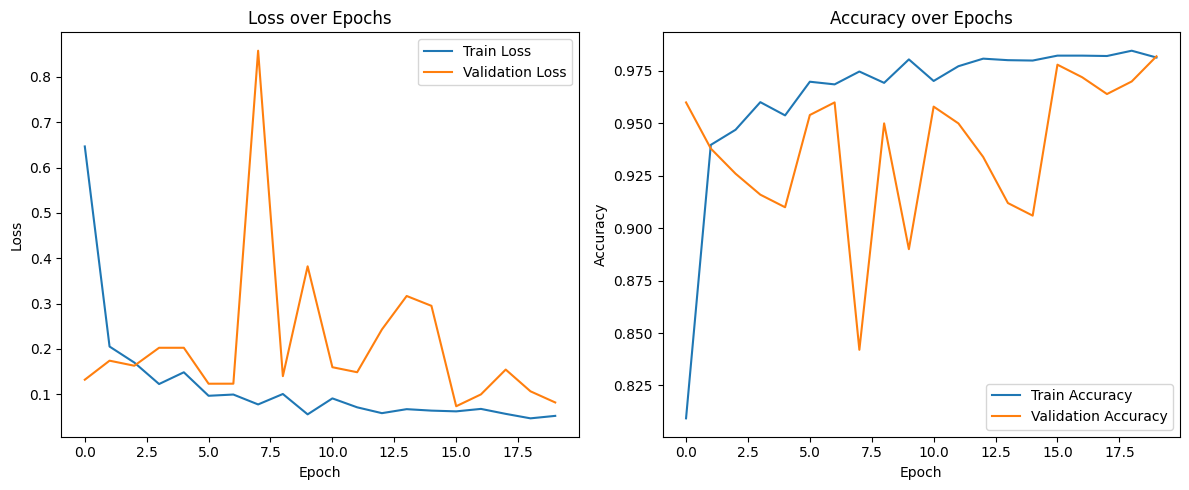

In [10]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Define training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
n_epochs = 20 
# Store metrics for plotting learning curves
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0
best_model_state = None

print("\n--- Training Model ---")
for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device) # Evaluate on validation set
    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        print(f"  --> New best model saved at epoch {epoch+1} with Val Acc: {best_val_acc:.4f}")

# After training, load the best model for final evaluation
if best_model_state:
    model.load_state_dict(best_model_state)
    print("\n[INFO] -- Loaded best model state for final evaluation.")

# Plotting learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation



--- Final Evaluation on Test Set (using best model) ---
Final Test Loss: 0.0820, Final Test Accuracy: 0.9820

--- Classification Report ---
              precision    recall  f1-score   support

         dws       0.98      0.93      0.95        67
         ups       0.94      0.99      0.96        77
         wlk       0.98      0.98      0.98       145
         jog       1.00      1.00      1.00        28
         std       1.00      1.00      1.00        59
         sit       1.00      1.00      1.00       124

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500


--- Confusion Matrix ---


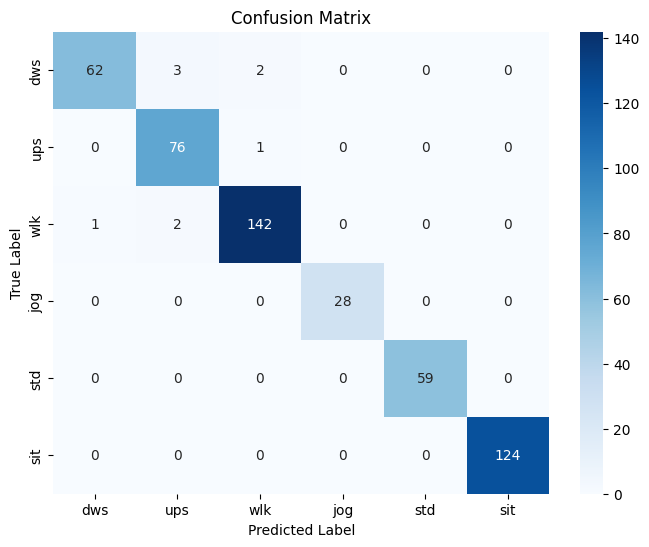

In [11]:
def evaluate(model, dataloader, criterion, device):
    """
    Evaluates the model and collects predictions/labels for detailed metrics.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)

# Final evaluation of the best model on the test set
print("\n--- Final Evaluation on Test Set (using best model) ---")
final_test_loss, final_test_acc, y_pred, y_true = evaluate(model, test_loader, criterion, device)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.4f}")

# --- Comprehensive Metrics and Visualizations ---
# Classification Report: Precision, Recall, F1-score for each class
print("\n--- Classification Report ---")
# Ensure target_names match the actual activity labels used for classification
target_names = [ACT_LABELS[i] for i in range(len(act_labels))]
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix: Visualizes correct vs. incorrect predictions per class
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

